In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson, nbinom
import seaborn as sns
import pandas as pd

from Model import Model
from PlaceInputs import PlaceInputs
from utils import *
import configs

# Parameters and Initialization

In [3]:
# Parameters
N_inp = 2000
N_bar = 2000
num_states = 100

In [4]:
place_inputs = PlaceInputs(N_inp, num_states).get_inputs()
model = Model(N_inp, N_bar, num_states)

In [5]:
cache_states = [n*10 for n in range(10)]

# Run Task

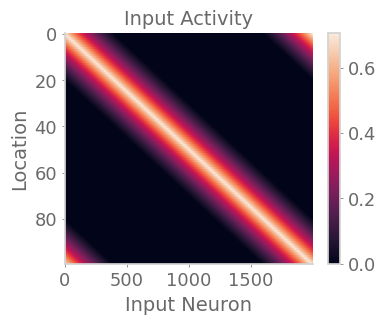

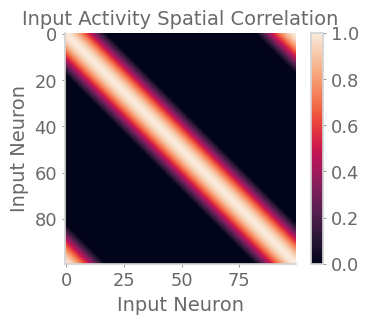

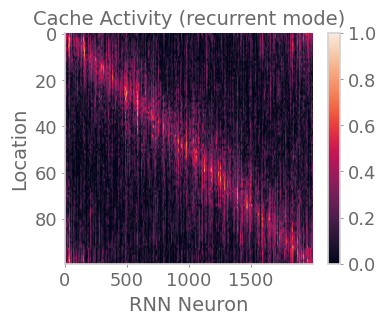

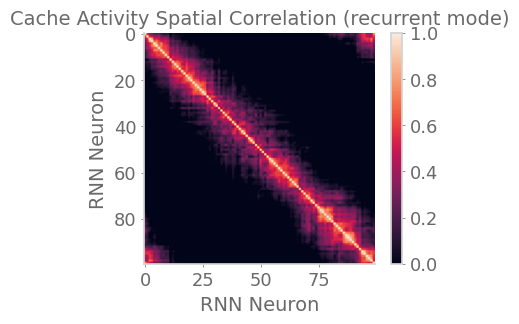

Sparsity: 0.31585


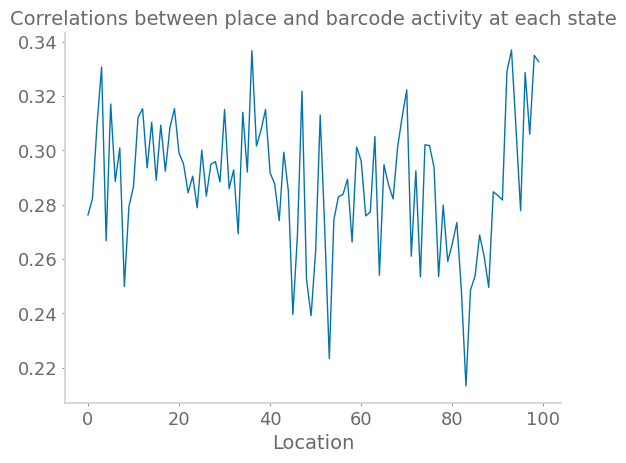

Now I just cached at location: 0


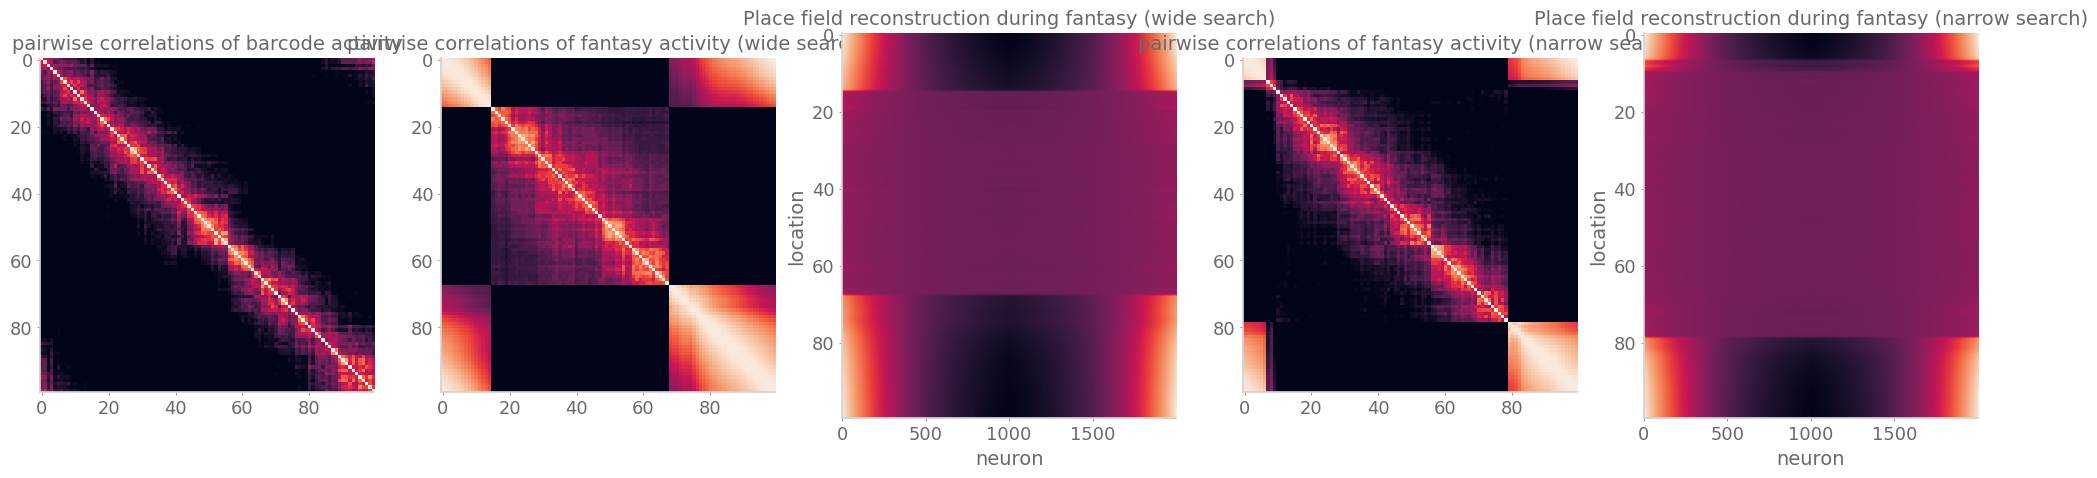

Now I just cached at location: 10


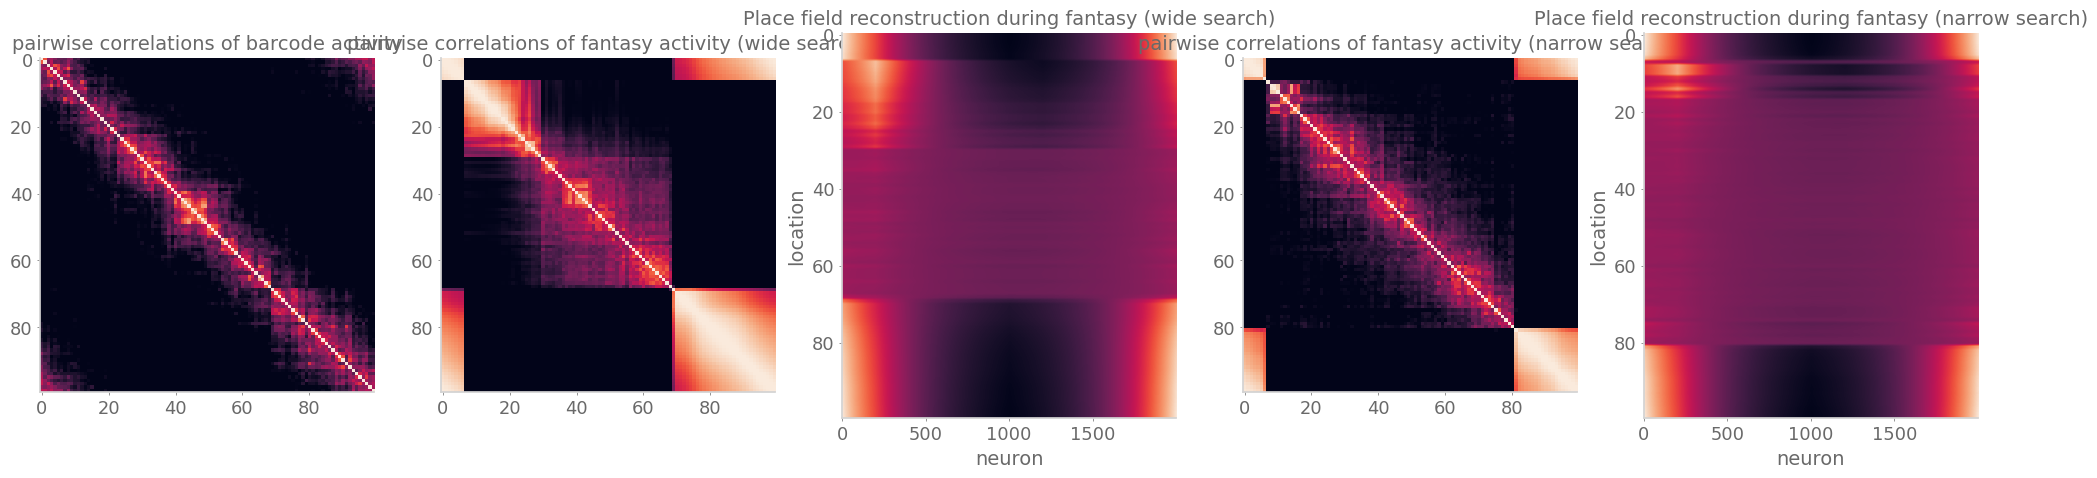

Now I just cached at location: 20


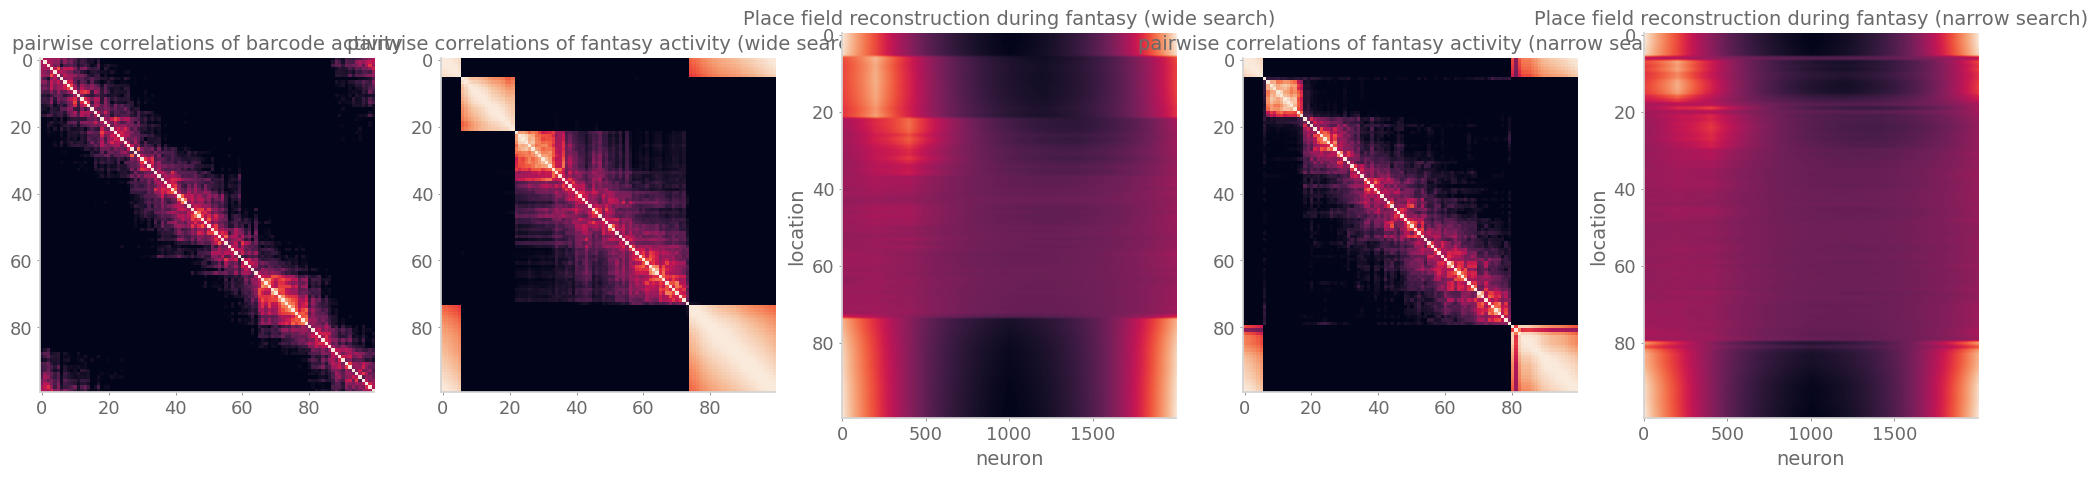

Now I just cached at location: 30


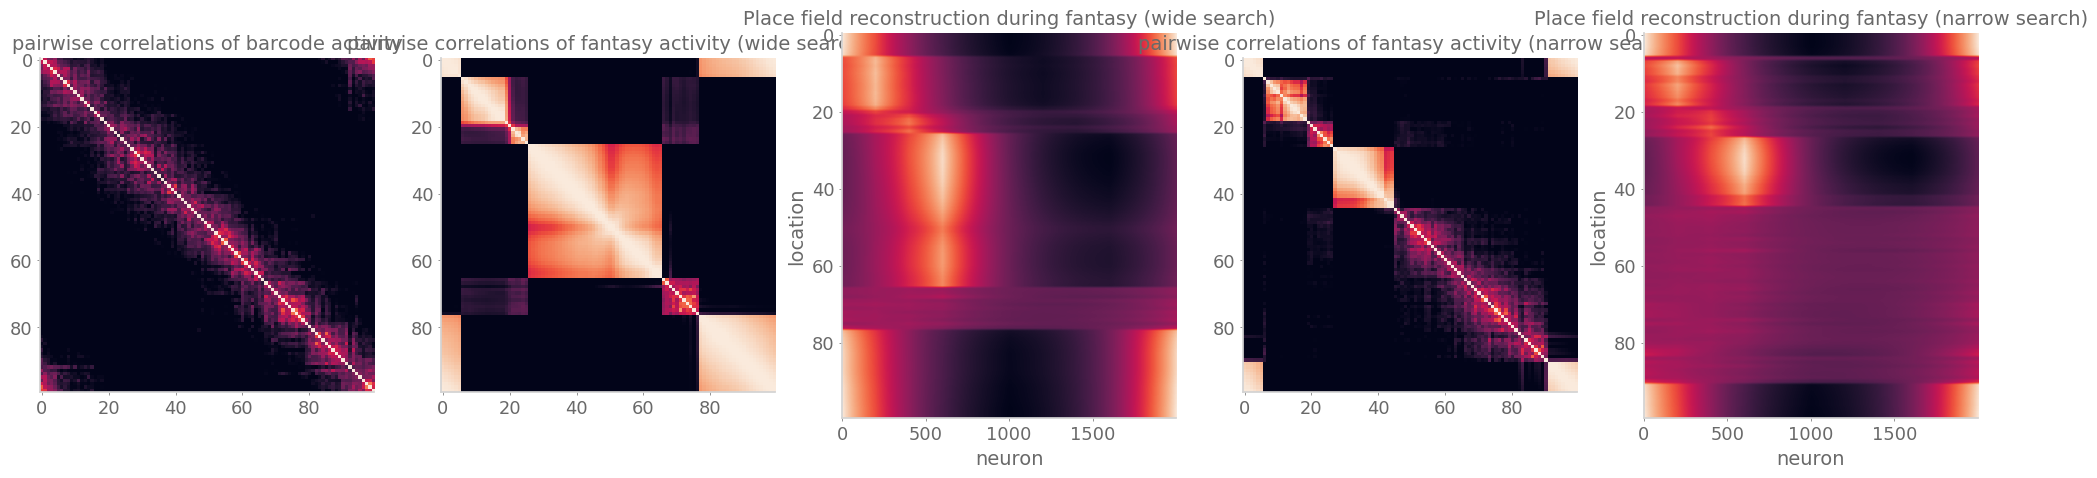

Now I just cached at location: 40


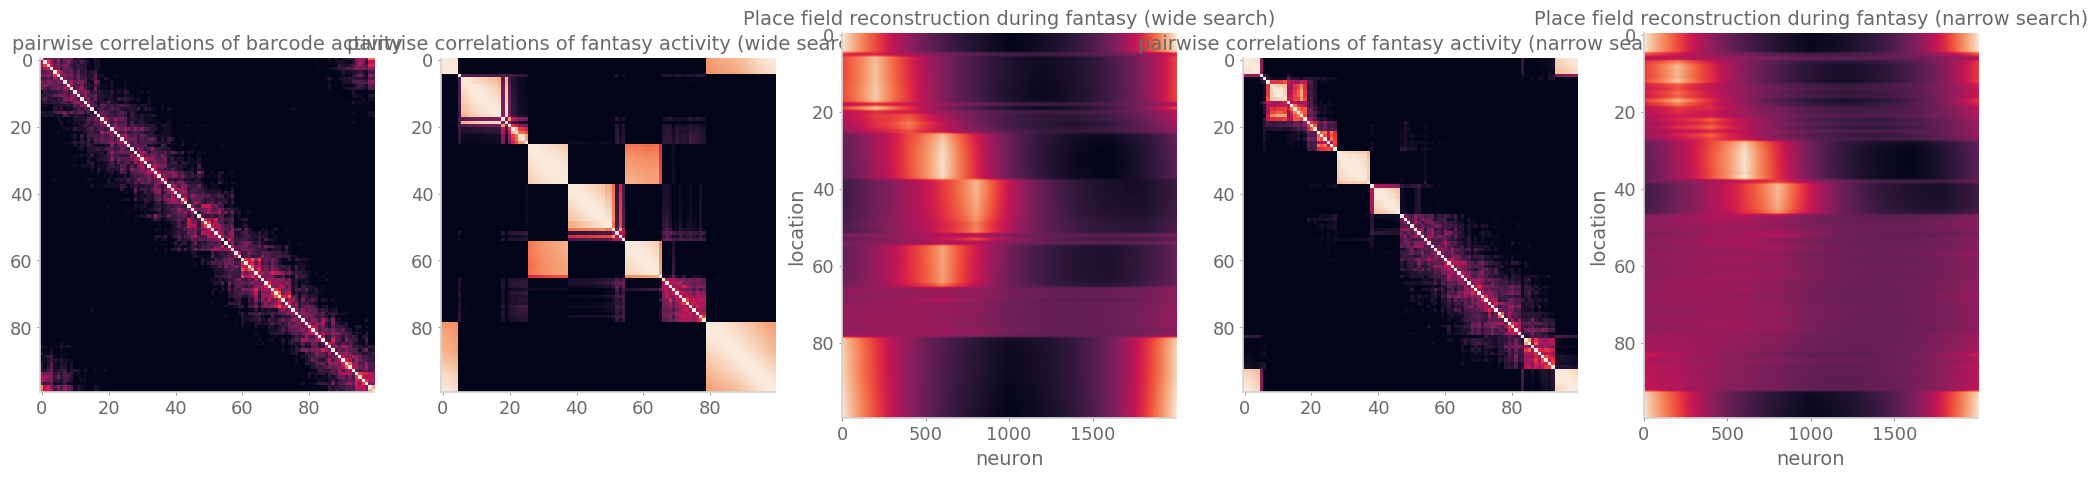

Now I just cached at location: 50


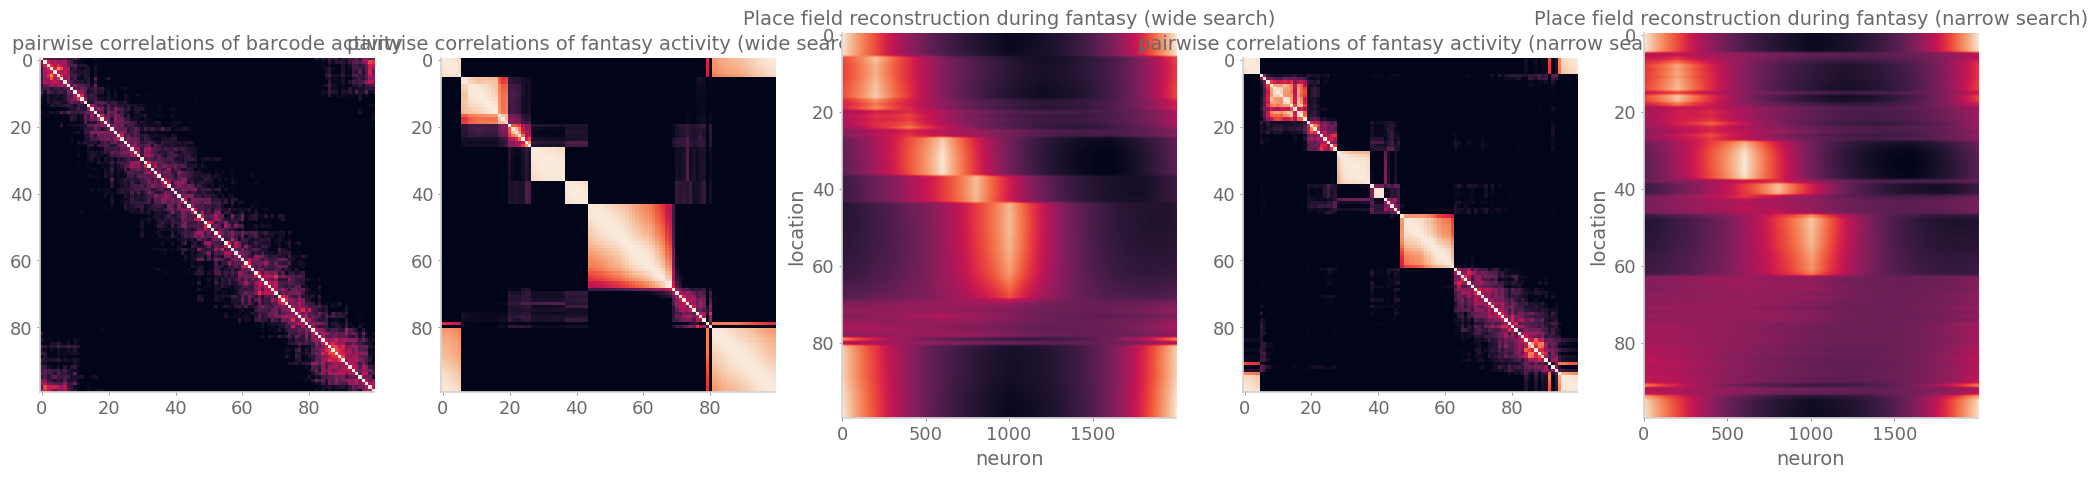

Now I just cached at location: 60


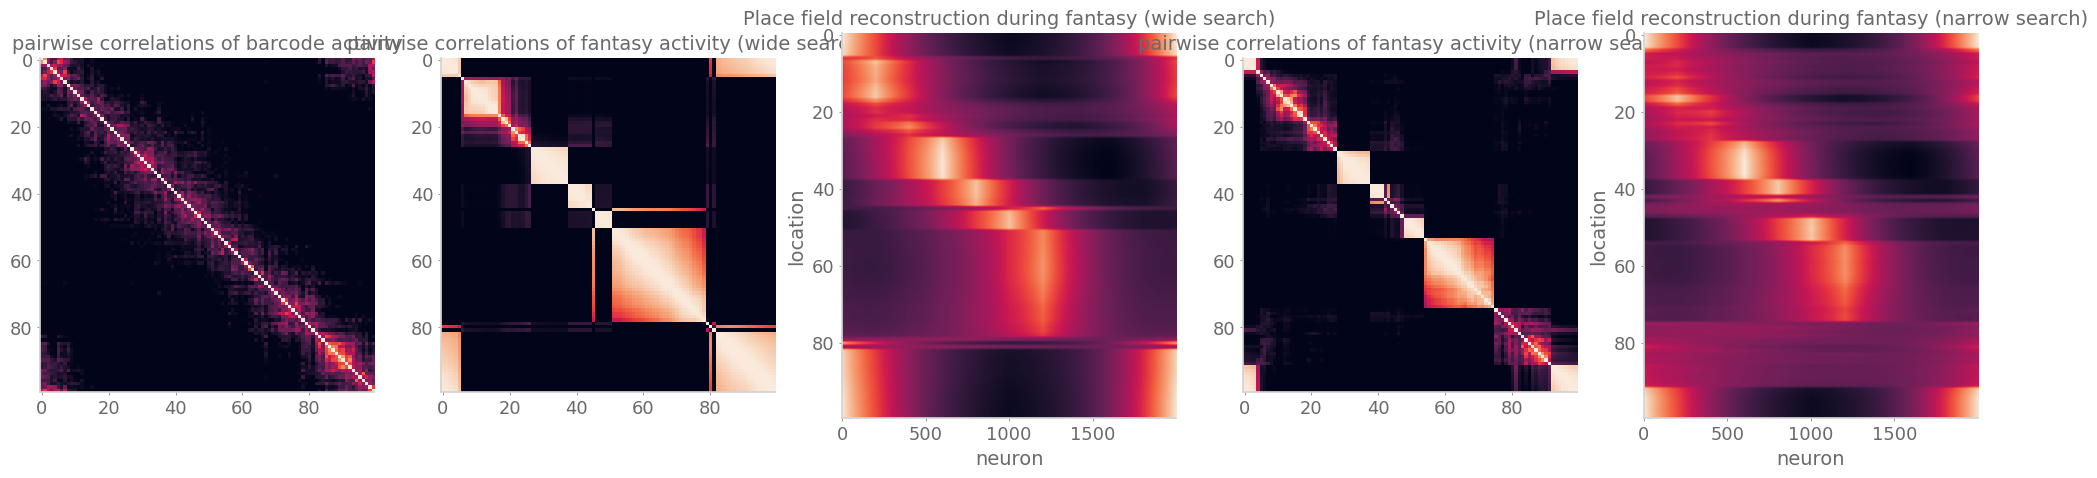

Now I just cached at location: 70


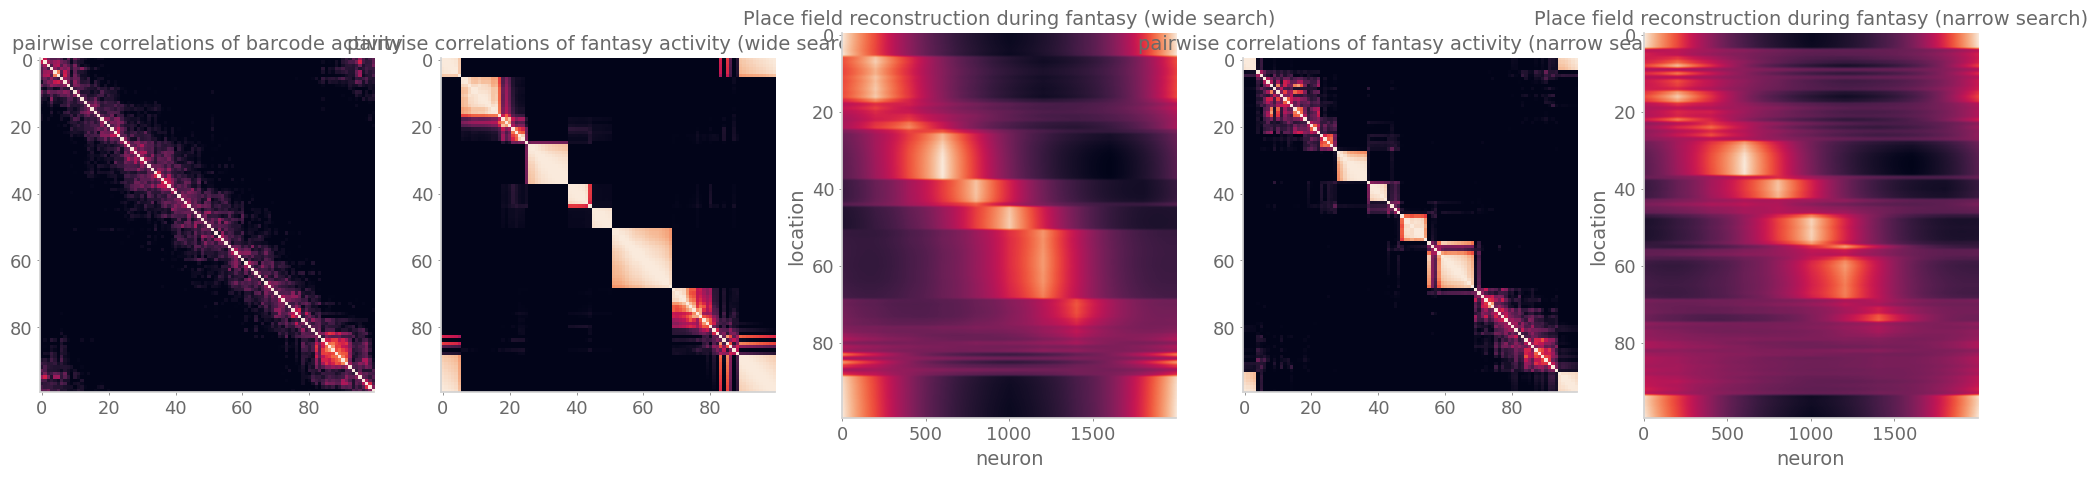

Now I just cached at location: 80


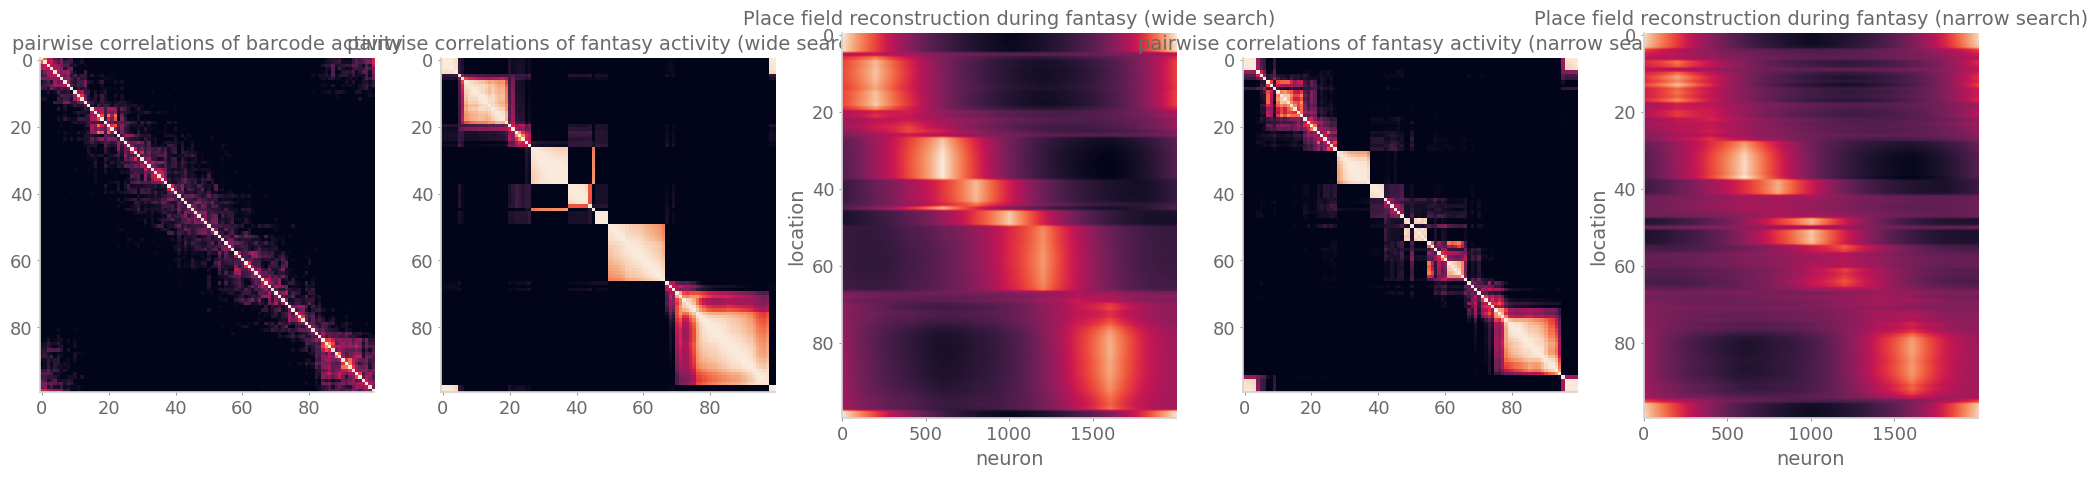

Now I just cached at location: 90


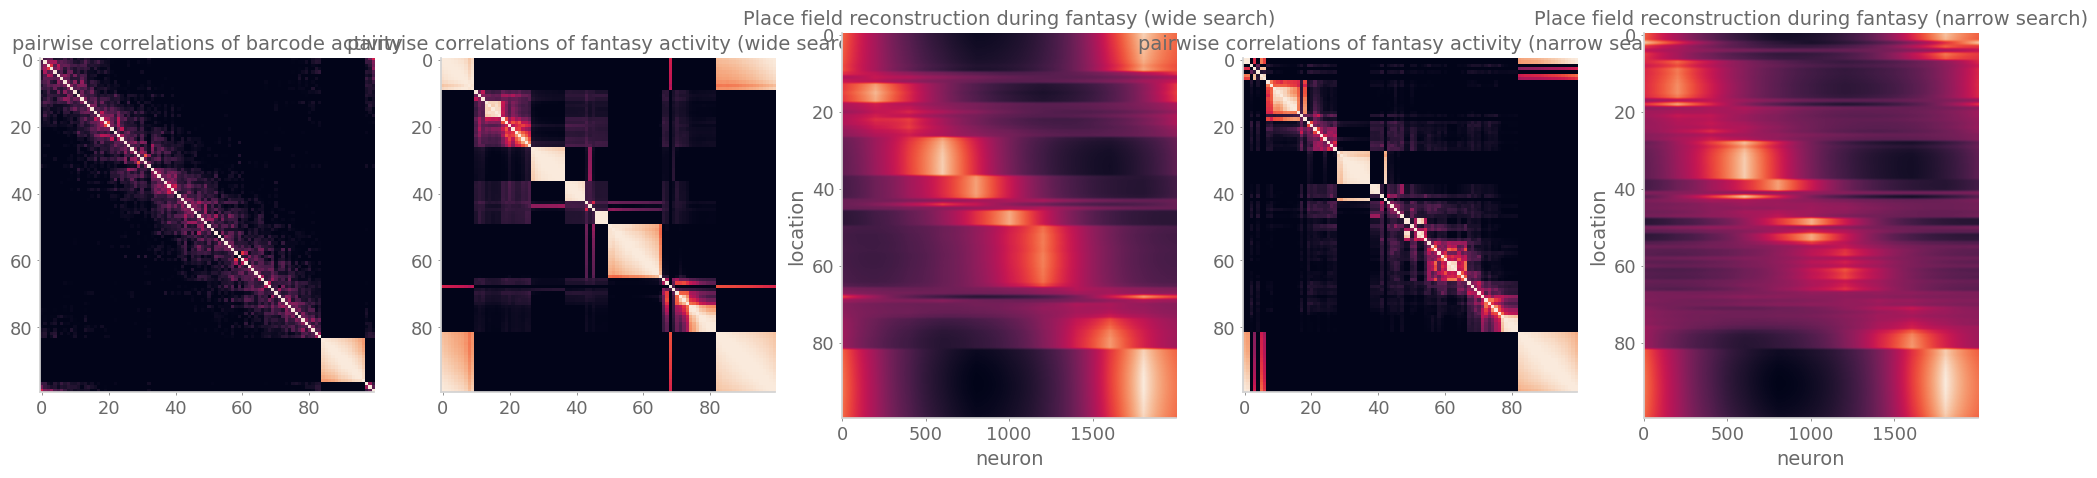

In [6]:
model.reset()
cache_acts = []
cache_acts_over_time = []
figsize=(4,3)

_, input_acts, _, _ = model.run_nonrecurrent(place_inputs)
plt.figure(figsize=figsize)
plt.imshow(input_acts, vmin=0,  aspect='auto')
plt.xlabel("Input Neuron")
plt.ylabel("Location")
plt.colorbar()
plt.title("Input Activity")
plt.show()

plt.figure(figsize=figsize)
plt.imshow(pairwise_correlations_centered(input_acts), vmin=0, vmax=1)
plt.colorbar()
plt.title("Input Activity Spatial Correlation")
plt.xlabel("Input Neuron")
plt.ylabel("Input Neuron")
plt.show()

_, acts, _, _ = model.run_recurrent(place_inputs)
plt.figure(figsize=figsize)
plt.imshow(acts, vmin=0, vmax=1, aspect='auto')
plt.xlabel("RNN Neuron")
plt.ylabel("Location")
plt.colorbar()
plt.title("Cache Activity (recurrent mode)")
plt.show()

plt.figure(figsize=figsize)
plt.imshow(pairwise_correlations_centered(acts), vmin=0, vmax=1)
plt.xlabel("RNN Neuron")
plt.ylabel("RNN Neuron")
plt.colorbar()
plt.title("Cache Activity Spatial Correlation (recurrent mode)")
plt.show()

print(f'Sparsity: {np.mean(acts>0)}')

acts_normalized = normalize(acts, ax=0)
inputs_normalized = normalize(input_acts, ax=0)
corrs = [np.corrcoef(acts_normalized[i], inputs_normalized[i])[0, 1] for i in range(num_states)]
plt.title("Correlations between place and barcode activity at each state")
plt.xlabel("Location")
plt.plot(corrs)
plt.show()

for cache_state in cache_states:
    
    fig, ax = plt.subplots(1, 5, figsize=(25, 5))
    
    print("Now I just cached at location:", cache_state)
    preacts, acts, _, acts_over_time = model.run_recurrent(place_inputs, n_zero_input=20)
    model.update(place_inputs[cache_state], acts[cache_state], preacts[cache_state])
    cache_acts.append(acts.copy())
    cache_acts_over_time.append(acts_over_time.copy())
    
    _, acts, _, _ = model.run_recurrent(place_inputs)
    ax[0].set_title("pairwise correlations of barcode activity")
    ax[0].imshow(pairwise_correlations_centered(acts), vmin=0, vmax=1)

    _, acts, reconstruct, _ = model.run_wide_recall(place_inputs)
    ax[1].set_title("pairwise correlations of fantasy activity (wide search)")
    ax[1].imshow(pairwise_correlations_centered(acts), vmin=0, vmax=1)
    ax[2].set_xlabel("neuron")
    ax[2].set_ylabel("location")
    ax[2].imshow(reconstruct, aspect='auto')
    ax[2].set_title("Place field reconstruction during fantasy (wide search)")
    
    _, acts, reconstruct, _ = model.run_narrow_recall(place_inputs)
    ax[3].set_title("pairwise correlations of fantasy activity (narrow search)")
    ax[3].imshow(pairwise_correlations_centered(acts), vmin=0, vmax=1)
    ax[4].set_xlabel("neuron")
    ax[4].set_ylabel("location")
    ax[4].imshow(reconstruct, aspect='auto')
    ax[4].set_title("Place field reconstruction during fantasy (narrow search)")
    plt.show()
    

In [11]:
preacts, acts, rr, acts_over_time = model.run_recurrent(place_inputs, n_zero_input=20)

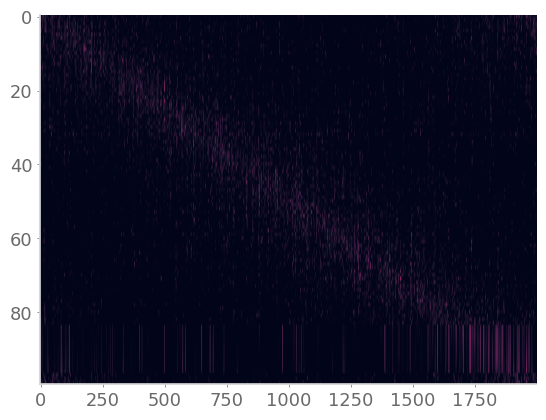

In [12]:
plt.figure()
plt.imshow(acts, aspect='auto')
plt.show()

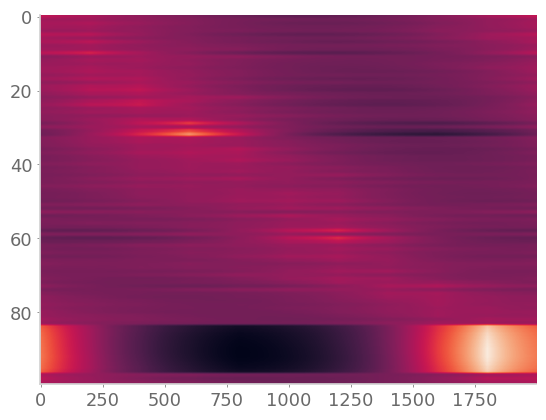

In [13]:
plt.figure()
plt.imshow(rr, aspect='auto')
plt.show()

# Fig 3ab, Fig 4: cache v. visit correlation

In [6]:
cache_cache_corr = {'Distance': [], 'Correlation': []}
cache_visit_corr = {'Distance': [], 'Correlation': []}
visit_visit_corr = {'Distance': [], 'Correlation': []}

sim_func = poiss_corr
for i in range(len(cache_states)):
    for j in range(i, len(cache_states)):
        _distance = distance(cache_states[i], cache_states[j], num_states)
        cache_act_i = cache_acts[i][cache_states[i]]
        cache_act_j = cache_acts[j][cache_states[j]]
        _, place_acts_1, _, _ = model.run_nonrecurrent(place_inputs)
        _, place_acts_2, _, _ = model.run_nonrecurrent(place_inputs)
        
        # Get correlations
        place_act_i = place_acts_1[cache_states[i]]
        place_act_j = place_acts_2[cache_states[j]]
        
        for _ in range(2):
            cache_scale = 1.
            place_scale = 0.5
            c_c_corr = sim_func(cache_act_i*cache_scale, cache_act_j*cache_scale)
            c_v_corr = sim_func(cache_act_i*cache_scale, place_act_j*place_scale)
            v_v_corr = sim_func(place_act_i*place_scale, place_act_j*place_scale)

            cache_cache_corr['Distance'].append(_distance)
            cache_cache_corr['Correlation'].append(c_c_corr)

            cache_visit_corr['Distance'].append(_distance)
            cache_visit_corr['Correlation'].append(c_v_corr)

            visit_visit_corr['Distance'].append(_distance)
            visit_visit_corr['Correlation'].append(v_v_corr)

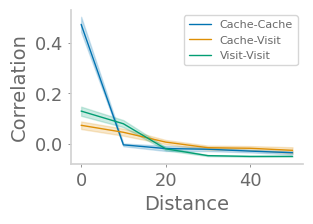

In [7]:
plt.figure(figsize=(3,2))
sns.lineplot(
    x='Distance', y='Correlation', 
    label='Cache-Cache', color='C0',
    data=pd.DataFrame(cache_cache_corr))
sns.lineplot(
    x='Distance', y='Correlation', 
    label='Cache-Visit', color='C1',
    data=pd.DataFrame(cache_visit_corr))
sns.lineplot(
    x='Distance', y='Correlation', 
    label='Visit-Visit', color='C2',
    data=pd.DataFrame(visit_visit_corr))
plt.legend()
plt.show()

# Fig 3c: Example barcodes and Fig 7: Projections in time

In [8]:
_, place_act, _, _ = model.run_nonrecurrent(place_inputs)
place_mean = np.mean(place_act, axis=0)

In [9]:
_cache_acts = []
for i in range(len(cache_states)):
    location = cache_states[i]
    _cache_acts.append(cache_acts[i][location])
cache_mean = np.mean(_cache_acts, axis=0)

In [10]:
locations = []
barcodes = []
all_cache = []
all_proj = []
all_place = []
place_proj_in_time = []
barcode_proj_in_time = []
for i in range(len(cache_states)):
    location = cache_states[i]
    
    # Cache activations
    _cache_act = cache_acts[i][location]
    _cache_act_over_time = cache_acts_over_time[i]
    _cache_act -= cache_mean
    
    # Place activations
    _place_act = place_act[location]
    _place_act -= place_mean
    _place_act /= np.linalg.norm(_place_act)
    
    # Define barcode
    all_cache.append(_cache_act.copy())
    all_place.append(_place_act.copy())
    projection = np.dot(_cache_act, _place_act) * _place_act
    all_proj.append(projection.copy())
    locations.append(location)
    barcode = _cache_act - projection
    _cache_act /= np.linalg.norm(_cache_act)
    barcodes.append(barcode)
    
    # Over time
    _place_proj_in_time = []
    _barcode_proj_in_time = []
    for t in range(_cache_act_over_time.shape[0]):
        _c = _cache_act_over_time[t][location] # (n_units,)
        _place_proj_in_time.append(np.dot(_c, _place_act))
        _barcode_proj_in_time.append(np.dot(_c, _cache_act))
    place_proj_in_time.append(_place_proj_in_time)
    barcode_proj_in_time.append(_barcode_proj_in_time)

In [11]:
if False:
    plt.figure()
    plt.plot(all_cache[4]-all_proj[4])
    plt.plot(all_place[4])
    plt.show()
    print(np.dot(all_cache[4]-all_proj[4], all_proj[4]))
    
    plt.figure()
    plt.plot(all_cache[4])
    plt.plot(all_proj[4])
    plt.show()
    print(np.dot(all_cache[4]-all_proj[4], all_proj[4]))

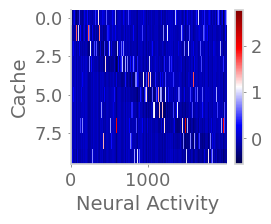

In [12]:
# Figure 3
x = np.array(barcodes)
plt.figure(figsize=(2.5,2))
plt.imshow(x, cmap='seismic', interpolation='nearest', aspect='auto')
plt.colorbar()
plt.ylabel('Cache')
plt.xlabel('Neural Activity')
plt.show()

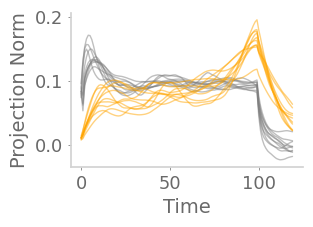

In [13]:
# Figure 7
plt.figure(figsize=(3,2))
for pp in place_proj_in_time:
    plt.plot(pp/np.linalg.norm(pp), alpha=0.5, color='gray')
for bp in barcode_proj_in_time:
    plt.plot(bp/np.linalg.norm(bp), alpha=0.5, color='orange')
plt.xlabel('Time')
plt.ylabel('Projection Norm')
plt.show()

# Fig 2: Barcode neuron participation

In [14]:
_, place_act, _, _ = model.run_nonrecurrent(place_inputs)
place_mean = np.mean(place_act, axis=0)
place_std = np.std(place_act, axis=0)

In [15]:
_cache_acts = []
for i in range(len(cache_states)):
    location = cache_states[i]
    _cache_acts.append(cache_acts[i][location])
cache_mean = np.mean(_cache_acts, axis=0)

In [16]:
activities = []
for i in range(len(cache_states)):
    location = cache_states[i]
    _cache_act = cache_acts[i][location].copy()
    _cache_act -= place_mean
    _cache_act /= place_std
    activities.append(_cache_act.copy())

In [17]:
x = np.array(activities)

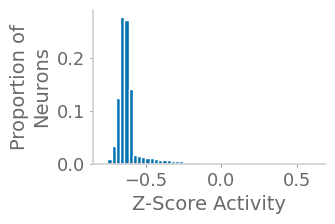

In [18]:
plt.figure(figsize=(3,2))
plt.hist(
    x.flatten(), bins=50,
    weights=[1/x.size]*x.size)
plt.ylabel('Proportion of\nNeurons')
plt.xlabel('Z-Score Activity')
plt.show()

In [19]:
vals = []
for i in range(x.shape[1]):
    _x = x[:,i]
    p = np.sum(_x<0)/_x.size
    vals.append(p)
val = np.mean(vals)
print(f'Neurons fire under their place mean in {val*100:.2f} % of Caches')

Neurons fire under their place mean in 99.41 % of Caches
